In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading in the dataset and viewing the first few rows
df_ford = pd.read_csv('updated_cleaned_ford_df.txt')
df_ford.head()

,Unnamed: 0,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0,Fiesta,2017,12000,Automatic,15944,Petrol,150.0,57.7,1.0
1,1,Focus,2018,14000,Manual,9083,Petrol,150.0,57.7,1.0
2,2,Focus,2017,13000,Manual,12456,Petrol,150.0,57.7,1.0
3,3,Fiesta,2019,17500,Manual,10460,Petrol,145.0,40.3,1.5
4,4,Fiesta,2019,16500,Automatic,1482,Petrol,145.0,48.7,1.0


In [3]:
# Dropping unwanted column
df_ford = df_ford.drop(columns=['Unnamed: 0'])

# Feature selection

In [4]:
# Turning categorical columns into numeric by one hot encoding
df_ford_dum = pd.get_dummies(df_ford, columns=['model', 'transmission', 'fuelType'], drop_first=True, dtype='int')

In [5]:
# Splitting the columns into features and the outcome variable
x = df_ford_dum.drop(columns=['price'])
y = df_ford_dum[['price']]

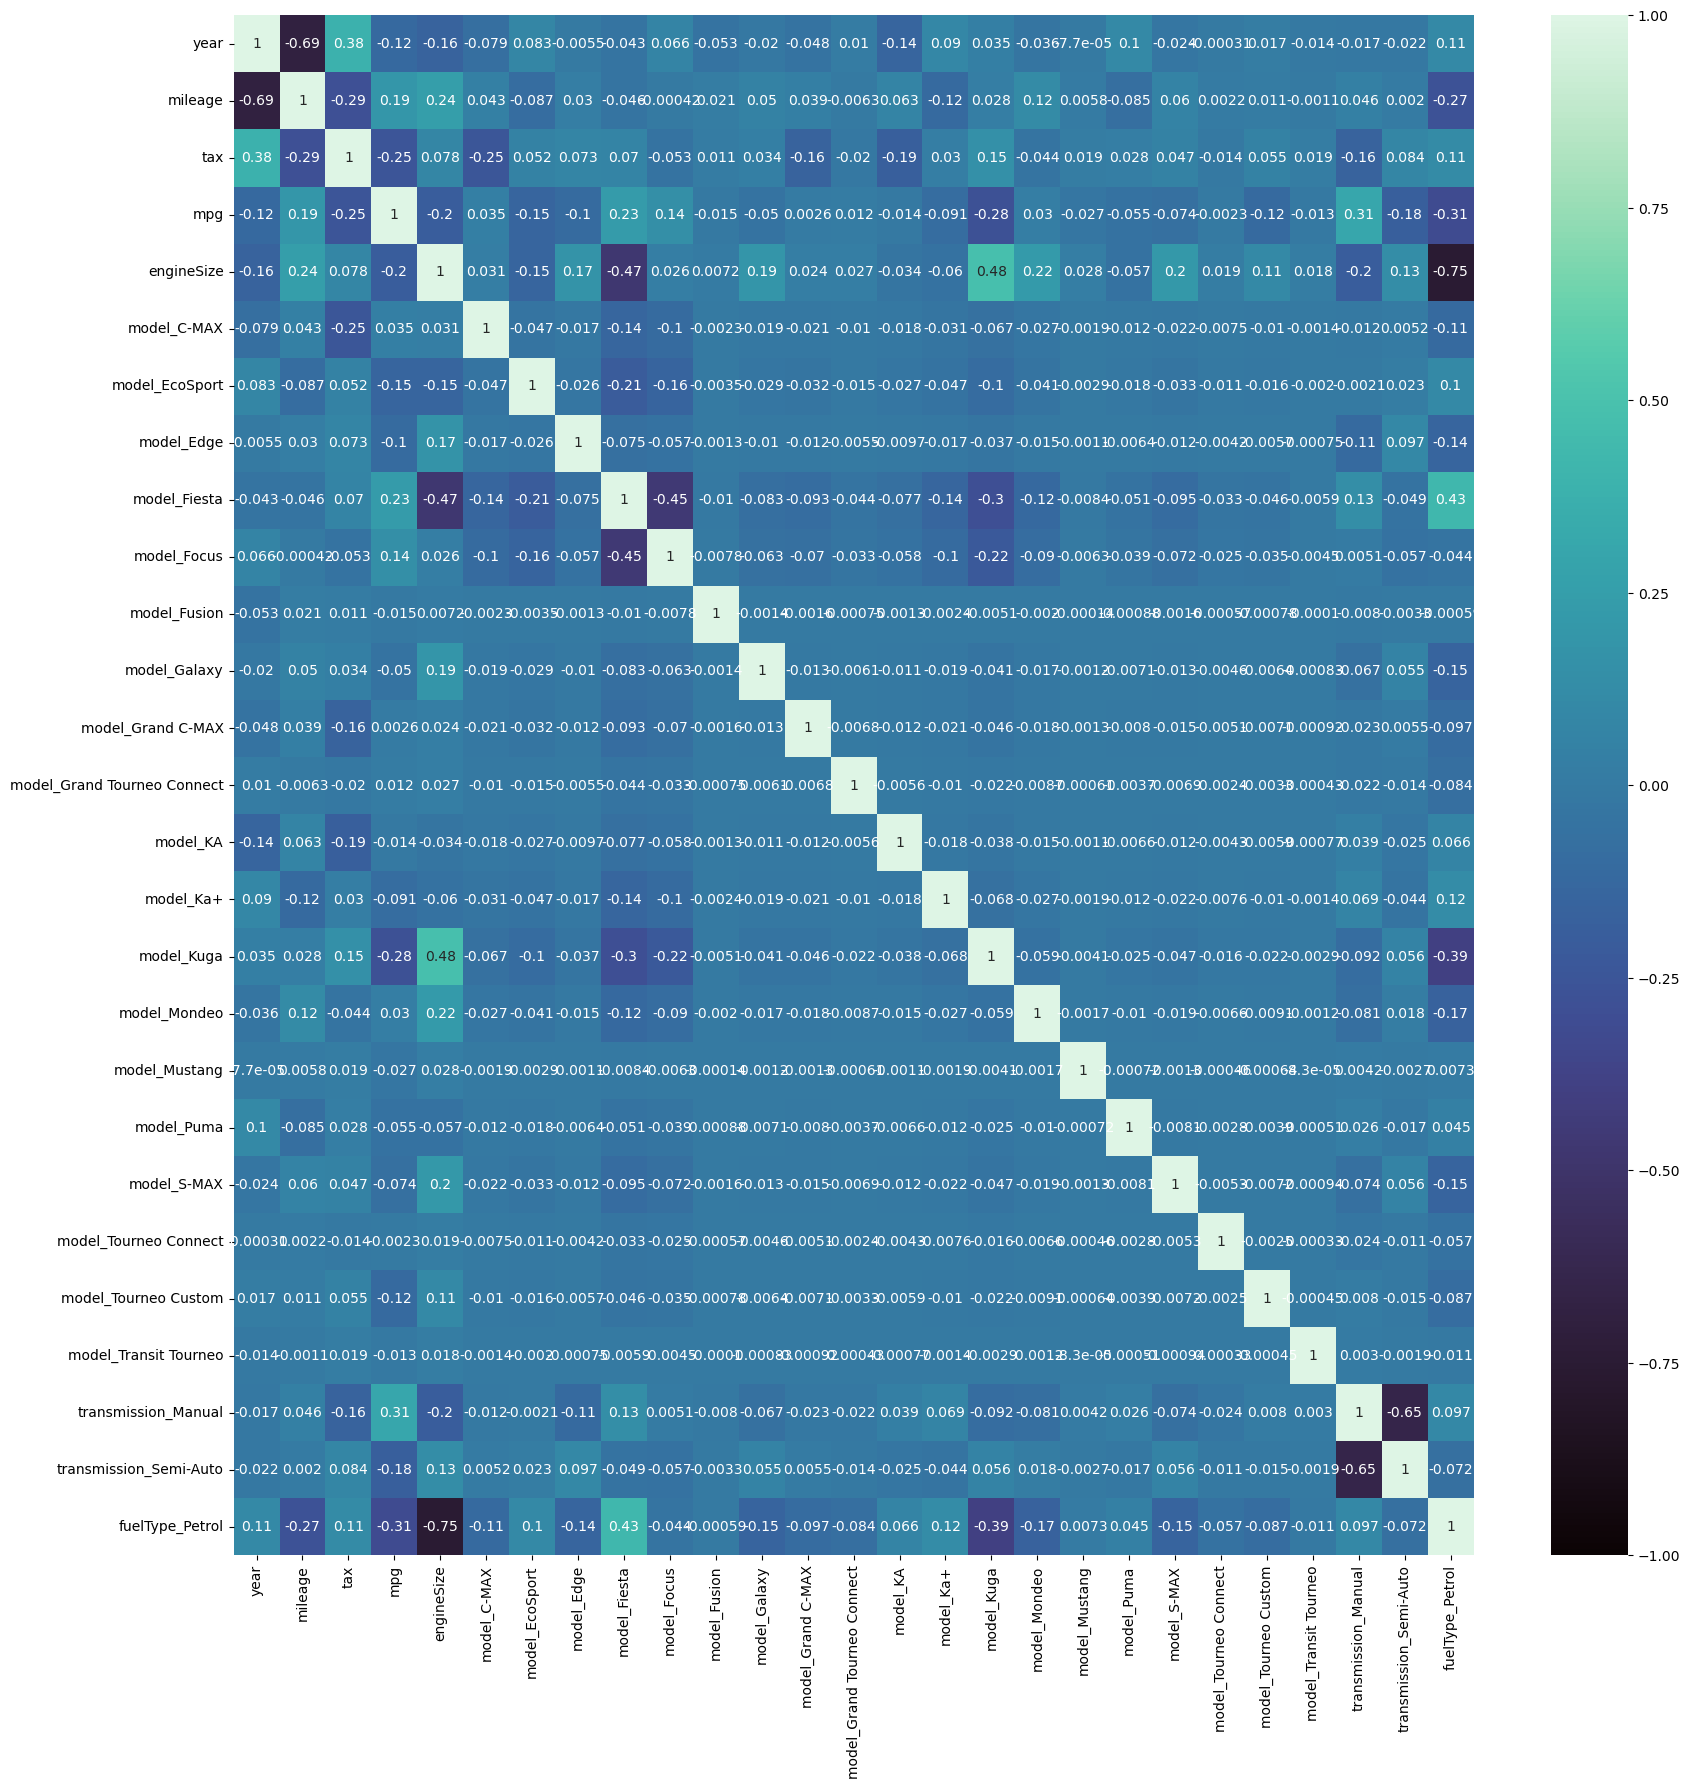

In [6]:
# Creating a correlation grid to see if any features are highly correlated
plt.figure(figsize=(20, 20))
sns.heatmap(x.corr(), xticklabels=x.columns, yticklabels=x.columns, vmin=-1, center=0, vmax=1, cmap='mako', annot=True)
plt.show()
# We can see that there is a high negative correlation between engine size and fueltype petrol
# Also transmission manual and semi-auto, and mileage with year

In [7]:
# Creating a subset of different features by removing highly correlated ones
x2 = df_ford_dum.drop(columns=['year', 'price', 'transmission_Semi-Auto', 'fuelType_Petrol'])
y2 = df_ford_dum[['price']]

# Train Test split

In [8]:
# Splitting the first set of features and outcome variable into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
# Splitting the second set of features and outcome variable into training and testing sets
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x2, y2, test_size=0.2, random_state=42)

# RFE

In [10]:
# Using RFE to select the 20 most relevant features
# Creating a linear regression model
lin_reg = LinearRegression()

# Creating a RFE model
rfe = RFE(estimator=lin_reg, n_features_to_select=20)

# Fitting the RFE model with the training data
rfe.fit(x_train, y_train)

# Getting the selected features
selected_features = rfe.support_

# Finding out which features/columns were chosen
selected_col = x.columns[selected_features]
selected_col

Index(['year', 'engineSize', 'model_EcoSport', 'model_Edge', 'model_Focus',
       'model_Fusion', 'model_Galaxy', 'model_Grand C-MAX',
       'model_Grand Tourneo Connect', 'model_KA', 'model_Ka+', 'model_Kuga',
       'model_Mondeo', 'model_Mustang', 'model_Puma', 'model_S-MAX',
       'model_Tourneo Connect', 'model_Tourneo Custom',
       'model_Transit Tourneo', 'fuelType_Petrol'],
      dtype='object')

In [11]:
# Transforming the x_train and x_test data to just have the selected features
x_train_3 = rfe.transform(x_train)
x_test_3 = rfe.transform(x_test)

# Scaling 

In [12]:
# Creating a standard scaler model
scaler = StandardScaler()

# Fitting and transforming the scaler to the training set
x_train_scaled = scaler.fit_transform(x_train)

# Transforming the testing set
x_test_scaled = scaler.transform(x_test)

In [13]:
# Creating a second standard scaler model
scaler_2 = StandardScaler()

# Fitting and transforming the scaler to the training set
x_train_2_scaled = scaler_2.fit_transform(x_train_2)

# Transforming the testing set
x_test_2_scaled = scaler_2.transform(x_test_2)

In [14]:
# Creating a second standard scaler model
scaler_3 = StandardScaler()

# Fitting and transforming the scaler to the training set
x_train_3_scaled = scaler_3.fit_transform(x_train_3)

# Transforming the testing set
x_test_3_scaled = scaler_3.transform(x_test_3)

# Linear Regression Model #1

In [15]:
# Creating a linear regression model
model = LinearRegression(fit_intercept=True)

# Fitting the model with the first set of training data
model.fit(x_train_scaled, y_train)

LinearRegression()

In [16]:
# Evaluating the model by getting the r-squared for both the training and testing data
print('R-squared for training data: ' + str(model.score(x_train_scaled, y_train)))
print('R-squared for testing data: ' + str(model.score(x_test_scaled, y_test)))

# Even though there a lot of features both the training and test sets have similar scores indicating no overfitting

R-squared for training data: 0.8514849454205309
R-squared for testing data: 0.8553305506074238


In [17]:
# Finding the y-intercept for the line
print('Y-intercept is ' + str(model.intercept_))

Y-intercept is [12242.66600529]


In [18]:
# Getting the predicted values for the x_test_scaled data
y_pred = model.predict(x_test_scaled) 

In [19]:
# Calculating the mean absolute error
model_mae = mean_absolute_error(y_test, y_pred)
print('Mean absolute error: ' + str(model_mae))

# Calculating the mean squared error
model_mse = mean_squared_error(y_test, y_pred)
print('Mean sqaured error: ' + str(model_mse))

# Calculating the root mean squared error
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root mean sqaured error: ' + str(model_rmse))

Mean absolute error: 1211.6414970832275
Mean sqaured error: 2405999.3984037344
Root mean sqaured error: 1551.1284274371785


In [20]:
# Creating a function to calculate adjusted r-squared
def adjusted_r2_score(y_test, y_pred, x):
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = x.shape[1]
    adjusted_r2 = 1 - (1-r2) * (n-1) / (n-p-1)
    return adjusted_r2

In [21]:
# Finding the adjusted r-squared for model 1
print('The adjusted R-squared: ' + str(adjusted_r2_score(y_test, y_pred,x)))

The adjusted R-squared: 0.8541728519904708


In [22]:
# Creating a function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_test, y_pred):
    Y_test, Y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100

In [23]:
# Finding the mean absolute percentage error for model 1
print('The mean absolute percentage error: ' + str(mean_absolute_percentage_error(y_test, y_pred)))

The mean absolute percentage error: 10.87294929915465


In [24]:
# Creating a pipeline to scale training data for each fold and avoid data leakage from the initial standardscaler
pipeline = make_pipeline(StandardScaler(), LinearRegression())

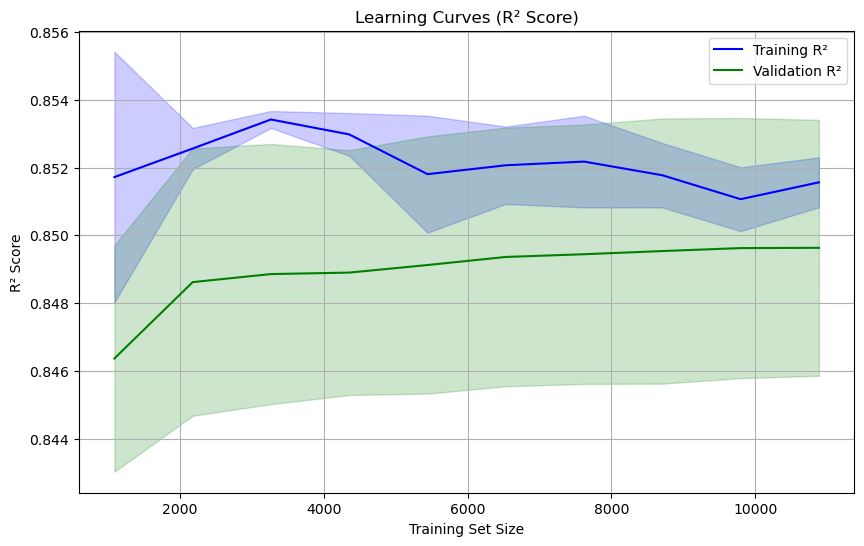

In [25]:
# Getting the learning curve data for the training and validation sets
train_sizes, train_scores, val_scores = learning_curve(pipeline, x_train, y_train, cv=5, scoring='r2', 
                                                       train_sizes=np.linspace(0.1, 1.0, 10), random_state=1)

# Calculate the mean and std for the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Visualising the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training R²', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation R²', color='green')

# Filling below and above the mean by 1 std for the training and validation sets
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, color='green', alpha=0.2)

plt.title('Learning Curves (R² Score)')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('model_1_learning_curve.png')
plt.show()

# Linear Regression Model #2

In [26]:
# Creating a second linear regression model
model_2 = LinearRegression()

# Fitting the model with the second set of training data
model_2.fit(x_train_2_scaled, y_train_2)

LinearRegression()

In [27]:
# Evaluating the model by getting the r-squared for both the training and testing data
print('R-squared for training data: ' + str(model_2.score(x_train_2_scaled, y_train_2)))
print('R-squared for testing data: ' + str(model_2.score(x_test_2_scaled, y_test_2)))

R-squared for training data: 0.7442274915316311
R-squared for testing data: 0.7416288503712539


In [28]:
# Getting the y-intercept for the line
print('Y-intercept is ' + str(model_2.intercept_))

Y-intercept is [12242.66600529]


In [29]:
# Getting the predicted values for the x_test_2_scaled data
y_pred_2 = model_2.predict(x_test_2_scaled) 

In [30]:
# Calculating the mean absolute error
model_2_mae = mean_absolute_error(y_test_2, y_pred_2)
print('Mean absolute error: ' + str(model_2_mae))

# Calculating the mean squared error
model_2_mse = mean_squared_error(y_test_2, y_pred_2)
print('Mean sqaured error: ' + str(model_2_mse))

# Calculating the root mean squared error
model_2_rmse = np.sqrt(mean_squared_error(y_test_2, y_pred_2))
print('Root mean sqaured error: ' + str(model_2_rmse))

Mean absolute error: 1647.5314216951729
Mean sqaured error: 4296973.778373585
Root mean sqaured error: 2072.9143200753824


In [31]:
# Finding the adjusted r-squared for model 2
print('The adjusted R-squared: ' + str(adjusted_r2_score(y_test_2, y_pred_2, x2)))

The adjusted R-squared: 0.7397926325474191


In [32]:
# Finding the mean absolute percentage error for model 2
print('The mean absolute percentage error: ' + str(mean_absolute_percentage_error(y_test_2, y_pred_2)))

The mean absolute percentage error: 14.796878885311028


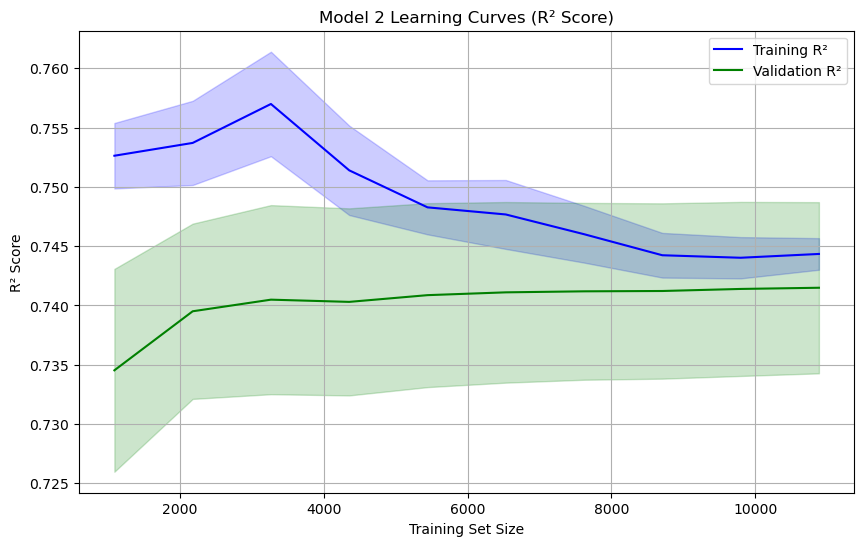

In [33]:
# Getting the learning curve data for the training and validation sets
train_sizes_2, train_scores_2, val_scores_2 = learning_curve(pipeline, x_train_2, y_train_2, cv=5, scoring='r2', 
                                                             train_sizes=np.linspace(0.1, 1.0, 10), random_state=1)

# Calculate the mean and std for the training and validation scores
train_scores_mean_2 = np.mean(train_scores_2, axis=1)
train_scores_std_2 = np.std(train_scores_2, axis=1)
val_scores_mean_2 = np.mean(val_scores_2, axis=1)
val_scores_std_2 = np.std(val_scores_2, axis=1)

# Visualising the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_2, train_scores_mean_2, label='Training R²', color='blue')
plt.plot(train_sizes_2, val_scores_mean_2, label='Validation R²', color='green')

# Filling below and above the mean by 1 std for the training and validation sets
plt.fill_between(train_sizes_2, train_scores_mean_2 - train_scores_std_2,
                 train_scores_mean_2 + train_scores_std_2, color='blue', alpha=0.2)
plt.fill_between(train_sizes_2, val_scores_mean_2 - val_scores_std_2,
                 val_scores_mean_2 + val_scores_std_2, color='green', alpha=0.2)

plt.title('Model 2 Learning Curves (R² Score)')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [34]:
# By removing the additional features with high correlation to model has performed significiantly worse across 
# all the evaluation methods.

# Linear Regression Model #3

In [35]:
# Creating a third linear regression model with the RFE features
model_3 = LinearRegression()

# Fitting the model with the second set of training data
model_3.fit(x_train_3_scaled, y_train)

LinearRegression()

In [36]:
# Evaluating the model by getting the r-squared for both the training and testing data
print('R-squared for training data: ' + str(model_3.score(x_train_3_scaled, y_train)))
print('R-squared for testing data: ' + str(model_3.score(x_test_3_scaled, y_test)))

R-squared for training data: 0.813709555801737
R-squared for testing data: 0.812789949018076


In [37]:
# Getting the y-intercept for the line
print('Y-intercept is ' + str(model_3.intercept_))

Y-intercept is [12242.66600529]


In [38]:
# Getting the predicted values for the x_test_3_scaled data
y_pred_3 = model_3.predict(x_test_3_scaled) 

In [39]:
# Calculating the mean absolute error
model_3_mae = mean_absolute_error(y_test, y_pred_3)
print('Mean absolute error: ' + str(model_3_mae))

# Calculating the mean squared error
model_3_mse = mean_squared_error(y_test, y_pred_3)
print('Mean sqaured error: ' + str(model_3_mse))

# Calculating the root mean squared error
model_3_rmse = np.sqrt(mean_squared_error(y_test, y_pred_3))
print('Root mean sqaured error: ' + str(model_3_rmse))

Mean absolute error: 1392.3718538988126
Mean sqaured error: 3113492.668485649
Root mean sqaured error: 1764.509186285424


In [40]:
# Finding the adjusted r-squared for model 3
print('The adjusted R-squared: ' + str(adjusted_r2_score(y_test, y_pred_3, x_train_3)))

The adjusted R-squared: 0.8116825248773962


In [41]:
# Finding the mean absolute percentage error for model 3
print('The mean absolute percentage error: ' + str(mean_absolute_percentage_error(y_test, y_pred_3)))

The mean absolute percentage error: 12.478827345660246


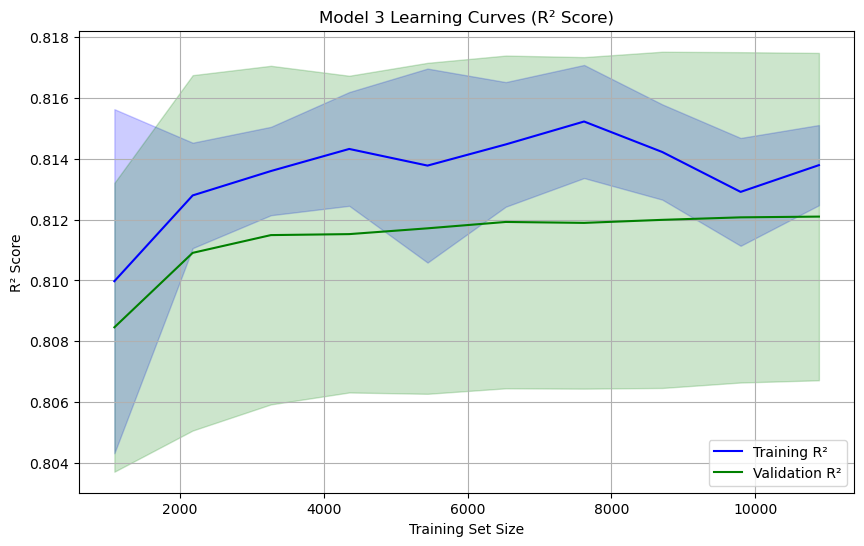

In [42]:
# Getting the learning curve data for the training and validation sets
train_sizes_3, train_scores_3, val_scores_3 = learning_curve(pipeline, x_train_3, y_train, cv=5, scoring='r2', 
                                                             train_sizes=np.linspace(0.1, 1.0, 10), random_state=1)

# Calculate the mean and std for the training and validation scores
train_scores_mean_3 = np.mean(train_scores_3, axis=1)
train_scores_std_3 = np.std(train_scores_3, axis=1)
val_scores_mean_3 = np.mean(val_scores_3, axis=1)
val_scores_std_3 = np.std(val_scores_3, axis=1)

# Visualising the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_3, train_scores_mean_3, label='Training R²', color='blue')
plt.plot(train_sizes_3, val_scores_mean_3, label='Validation R²', color='green')

# Filling below and above the mean by 1 std for the training and validation sets
plt.fill_between(train_sizes_3, train_scores_mean_3 - train_scores_std_3,
                 train_scores_mean_3 + train_scores_std_3, color='blue', alpha=0.2)
plt.fill_between(train_sizes_3, val_scores_mean_3 - val_scores_std_3,
                 val_scores_mean_3 + val_scores_std_3, color='green', alpha=0.2)

plt.title('Model 3 Learning Curves (R² Score)')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [43]:
# By removing 7 features the model has performed slightly worse than the first model with all the features. 
# However it has performed much better than model 2 which only removed 3 features.

# Model 1 Feature coefficients

In [44]:
# Seeing the most impactful coef for the first model, by printing the column name with the coef
predictors = x.columns
coef = model.coef_

# Removing the the outside list on the coef to just be a singular list
coef_flatten = np.array(coef).flatten().tolist()

In [45]:
# Putting the predictors and coefficients into a dataframe
pred_coef = pd.DataFrame({'Predictors':predictors, 'Coefficients':coef_flatten})
pred_coef

,Predictors,Coefficients
0,year,2038.013760
1,mileage,-997.435925
2,tax,-32.009585
3,mpg,-520.394210
4,engineSize,1132.245251
5,model_C-MAX,153.280283
6,model_EcoSport,344.927017
7,model_Edge,739.825224
8,model_Fiesta,370.674738
9,model_Focus,1204.663043


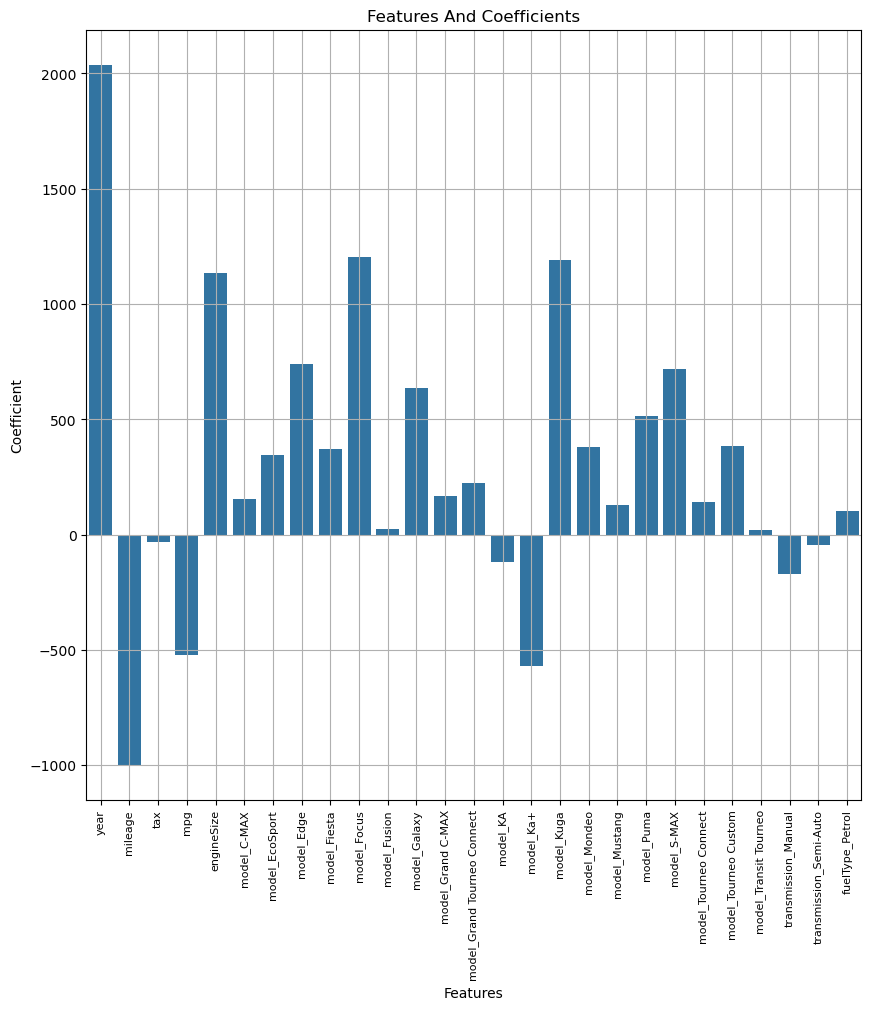

In [46]:
# Visualising the features and there coefficients
plt.figure(figsize=(10,10))
sns.barplot(x=predictors, y=coef_flatten, data=pred_coef)
plt.title('Features And Coefficients')
plt.ylabel('Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=90, size=8)
plt.grid(True)
plt.savefig('model_1_features_&_coefficients_graph.png')
plt.show()

# Actual vs Predicted

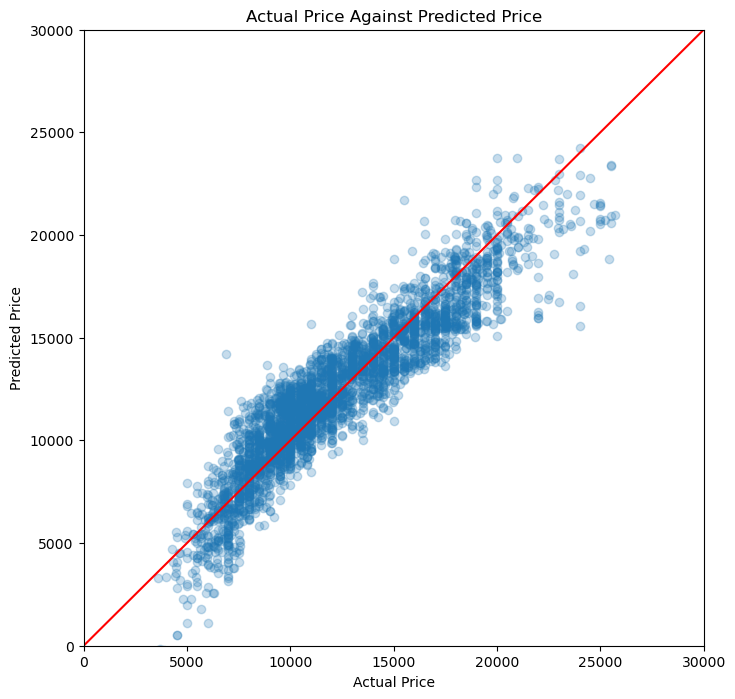

In [47]:
# Visualising the y_pred against the actual y_values, to see how accurate the model is
plt.figure(figsize=(8,8))
ax = plt.subplot()
plt.scatter(y_test, y_pred, alpha=0.25)
ax.axline((0,0), slope=1, color='red')
plt.title('Actual Price Against Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.xlim(0, 30000)
plt.ylim(0, 30000)
plt.savefig('scatter_actual_vs_predicted.png')
plt.show()

# Making Prediction

In [48]:
# Predictions - year-2015, mileage-50000, tax-200, mpg-50, enginesize-2.2, model-focus, transmission-manual
pred_1 = np.array([2015,50000,200,50,2.2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]).reshape(1, -1)

# Scaling the prediction
pred_1_scaled = scaler.transform(pred_1)

# Getting the predicted price
model.predict(pred_1_scaled)

array([[11741.48387414]])

# Checking Assumptions - Normality

In [49]:
# Getting the fitted values
fitted_values = model.predict(x_train_scaled)

# Getting the residuals
residuals = y_train - fitted_values

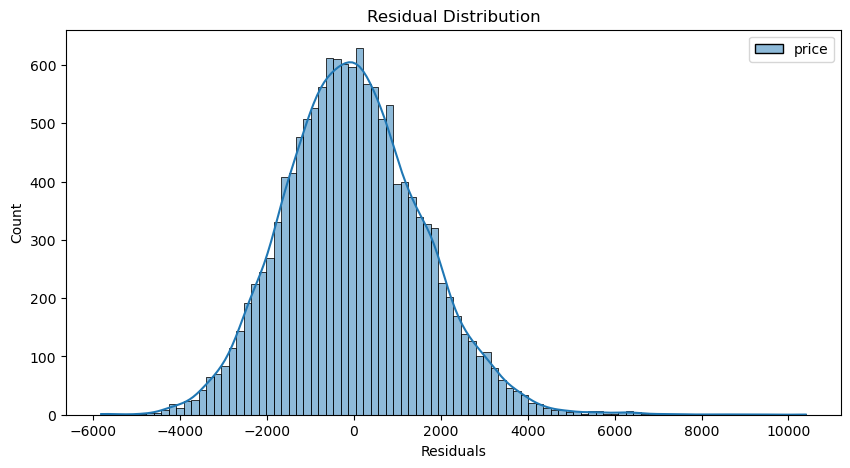

In [50]:
# Normality Assumption
# Checking the the residuals are normally distributed
plt.figure(figsize=(10,5))
sns.histplot(data=residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
#plt.savefig('histo_residual_dist.jpeg')
plt.show()
# The residuals are almost normally distributed, slight right skew

In [51]:
# Checking how many residuals are causing the skew
residuals.sort_values(by='price', ascending=False).head(10)
# Only the top 6 highest residuals are responsible for the slight skew in the distribution

,price
14216,10395.991176
13900,9431.166223
12600,9018.103834
12279,8691.416573
1901,8265.851012
91,8133.002194
12908,7479.981246
13561,7475.708418
9745,7267.328707
16383,7236.228683


In [52]:
# Removing those 6 residuals
residuals_2 = residuals.drop(labels=[14216, 13900, 12600, 12279, 1901, 91], axis=0)

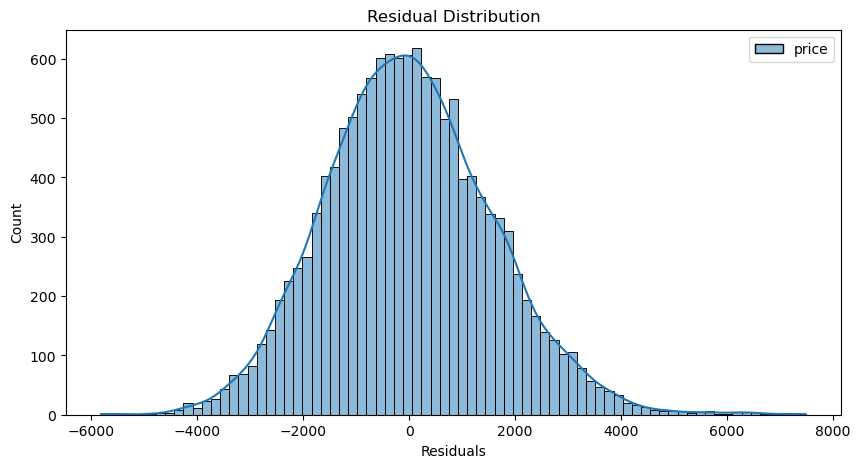

In [53]:
# Normality Assumption #2
# Visualising the distribution of residuals_2
plt.figure(figsize=(10,5))
sns.histplot(data=residuals_2, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.show()

# Checking Assumptions - Homoscedasticity

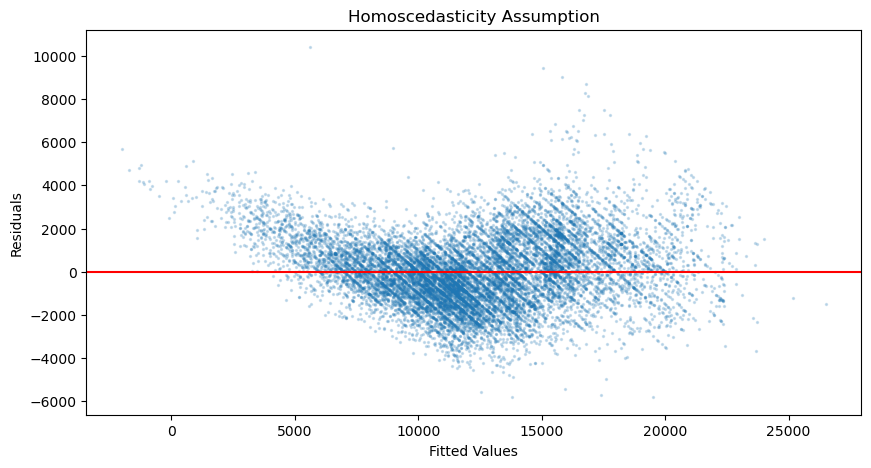

In [54]:
# Homoscedasticity Assumption
# Visualising the fitted values against their residuals
plt.figure(figsize=(10,5))
plt.scatter(fitted_values, residuals, s=2, alpha=0.2)
plt.title('Homoscedasticity Assumption')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red')
#plt.savefig('scatter_homoscedasticity.jpeg')
plt.show()
# we can see that the variation in residuals is fairly equal but again there are a few datapoints on the upper limit

In [55]:
# Adding fitted values to residual df
residuals['fitted'] = fitted_values
# Removing those 5 residuals
residuals_2 = residuals.drop(labels=[14216, 13900, 12600, 12279, 1901, 91], axis=0)

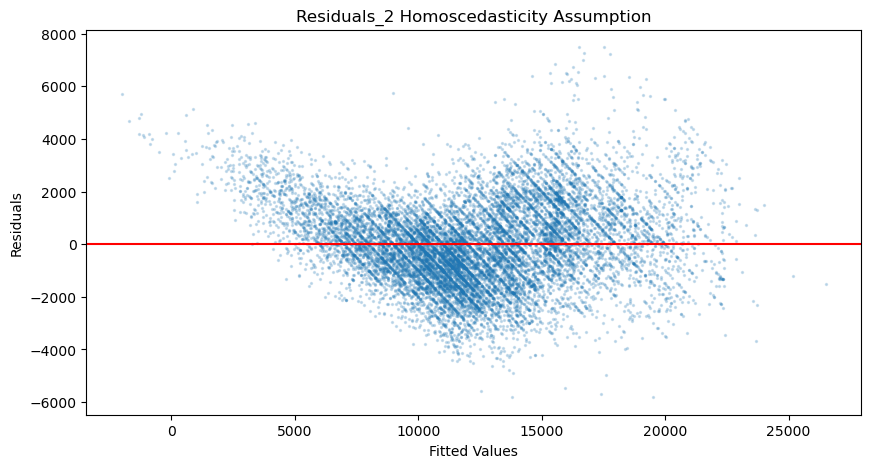

In [56]:
# Visualising the fitted values against their residuals_2
plt.figure(figsize=(10,5))
plt.scatter(residuals_2.fitted, residuals_2.price, s=2, alpha=0.2)
plt.title('Residuals_2 Homoscedasticity Assumption')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red')
#plt.savefig('scatter_99%_homoscedasticity.jpeg')
plt.show()

# The variation is slightly better
# But the model does seem to have bias, when the fitted value is low under 4000, the residual is always positive,
# this means are model is under pricing the car on every occasion

# Make your own prediction

In [57]:
# In the cell below is a where you can enter in the characteristics of a ford car and get the price prediction
# I will explain what each number corrosponds to
# Number 1 is the year of the car
# Number 2 is the mileage of the car
# Number 3 is the tax
# Number 4 is the mpg of the car
# Number 5 is the engine size of the car
# The next 18 numbers are for the model. Enter 1 for your model and 0 for the rest. If your model is B-Max enter 0 for all models
# Number 6 is the model C-MAX
# Number 7 is the model EcoSport
# Number 8 is the model Edge
# Number 9 is the model Fiesta
# Number 10 is the model Focus
# Number 11 is the model Fusion
# Number 12 is the model Galaxy
# Number 13 is the model Grand C-MAX
# Number 14 is the model Grand Tourneo Connect
# Number 15 is the model KA
# Number 16 is the model Ka+
# Number 17 is the model Kuga
# Number 18 is the model Mondeo
# Number 19 is the model Mustang
# Number 20 is the model Puma
# Number 21 is the model S-MAX
# Number 22 is the model Tourneo Connect
# Number 23 is the model Tourneo Custom
# Number 24 is the transmission manual. Leave as 0 if the car is semi or automatic
# Then run the cell and get your predictions

In [58]:
# Predict your price
your_prediction = np.array([2018,50000,200,50.0,2.2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]).reshape(1, -1)

your_prediction_scaled = scaler.transform(your_prediction)

model.predict(your_prediction_scaled)

array([[15405.88558462]])